In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup as bs
import urllib, cStringIO
import urllib2
from PIL import Image
import pickle
import ftfy
from time import time
import re
import gzip
import os
from matplotlib import pyplot as plt
%matplotlib inline
import cv2

In [2]:
zap = pd.read_csv('/users/Gene/Desktop/gzdsi7/Capstone/zappos_clean.csv')


In [3]:
zap.drop(['shoe_link','bottomview'], axis = 1, inplace=True)

In [4]:
zap.dropna(inplace=True)

In [5]:
zap.shoe_name = zap.shoe_name.apply(lambda x: unicode(x, "utf8", errors="ignore"))


In [6]:
zap.shoe_name = zap.shoe_name.apply(lambda x: x.replace('(Little Kid/Big Kid)',''))

In [7]:
zap.shoe_name = zap.shoe_name.apply(lambda x: x.replace('(Toddler)',''))

In [8]:
zap.shoe_name = zap.shoe_name.apply(lambda x: x.replace('(Infant/Toddler)',''))

In [9]:
zap.shoe_name = zap.shoe_name.apply(lambda x: x.replace('(Little Kid)',''))

In [10]:
zap.shoe_name = zap.shoe_name.apply(lambda x: x.replace('(Big Kid)',''))

In [11]:
zap.shoe_name = zap.shoe_name.apply(lambda x: x.replace('(Toddler/Little Kid)',''))

In [12]:
zap.shoe_name = zap.shoe_name.apply(lambda x: x.replace('(Toddler/Little Kid/Big Kid)',''))

In [13]:
zap.shoe_name = zap.shoe_name.apply(lambda x: x.replace('(Little Kid/Bid Kid)',''))

In [14]:
zap.shoe_name = zap.shoe_name.apply(lambda x: x.replace('(Infant)',''))

In [15]:
zap.shoe_name = zap.shoe_name.apply(lambda x: x.replace('(Big Kids)',''))

In [16]:
zap.colorcode = zap.colorcode.astype(str)

In [17]:
zap.lateralfrontleft = zap.lateralfrontleft.apply(lambda x: x.replace('http://http://','http://'))
zap.heelview = zap.heelview.apply(lambda x: x.replace('http://http://','http://'))
zap.toeview = zap.toeview.apply(lambda x: x.replace('http://http://','http://'))
zap.medialfrontright = zap.medialfrontright.apply(lambda x: x.replace('http://http://','http://'))
zap.topview = zap.topview.apply(lambda x: x.replace('http://http://','http://'))

In [18]:
def image_fetch(url):
    sample = cStringIO.StringIO(urllib.urlopen(url).read())
    img = Image.open(sample)
    image_array = np.array(img)
    resized_image_array = cv2.resize(image_array, (224, 224))
    return resized_image_array

In [19]:
import boto3

def to_bucket(f, bucket):
    '''
    Write files to s3 bucket.

    INPUT: f - file to write
           bucket - bucket to write to
           dum - dummyfile
    '''
    s3 = boto3.resource('s3')
    data = open(f, 'rb')
    s3.Bucket(bucket).put_object(Key=f,Body=data)
    print "Success! {} added to {} bucket".format(f, bucket)


In [20]:
from socket import error as SocketError
import errno

In [21]:
# iterate through each row in the df
def pickling(df):
    
    brand_dict = dict(zip(df.brand_name.unique(),range(0,len(df.brand_name.unique()))))
    shoe_dict = dict(zip(df.shoe_name.unique(),range(0,len(df.shoe_name.unique()))))
    color_dict = dict(zip(df.colorway,df.colorcode))

    for index, row in df.iterrows():
        #print index, row[4]
        try:
            brand = row['brand_name']
            shoe = row['shoe_name']
            color = row['colorway']
            dir_name = str(brand_dict[brand]) + '_' + str(shoe_dict[shoe]) + '_' + str(color_dict[color])
            shoeview_dict = {'lateralfrontleft': image_fetch(row[4]),
                             'heelview': image_fetch(row[5]),
                             'toeview': image_fetch(row[6]),
                             'medialfrontright': image_fetch(row[7]),
                             'topview': image_fetch(row[8]),
                             }


            file_name = dir_name
            fileObject = open(file_name, 'wb')
            pickle.dump(shoeview_dict, fileObject)
            fileObject.close()
            to_bucket(file_name, 'capstoneshoes')
            os.remove(file_name)
            
        except SocketError as e:
            if e.errno != errno.ECONNRESET:
        # Not error we are looking for
                pass # Handle error here.
        except IOError as err:
            pass
    print 'finished'

In [87]:
import cProfile
cProfile.run('pickling(zap.iloc[0:10])')

Success! 0_0_684832 added to capstoneshoes bucket
Success! 0_0_684828 added to capstoneshoes bucket
Success! 1_1_338019 added to capstoneshoes bucket
Success! 0_2_684520 added to capstoneshoes bucket
Success! 0_2_684517 added to capstoneshoes bucket
Success! 2_3_1163 added to capstoneshoes bucket
Success! 3_4_864 added to capstoneshoes bucket
Success! 3_5_129593 added to capstoneshoes bucket
Success! 3_6_515 added to capstoneshoes bucket
Success! 0_2_684046 added to capstoneshoes bucket
Success! 0_0_684832 added to capstoneshoes bucket
Success! 0_0_684828 added to capstoneshoes bucket
Success! 1_1_338019 added to capstoneshoes bucket
Success! 0_2_684520 added to capstoneshoes bucket
Success! 0_2_684517 added to capstoneshoes bucket
Success! 2_3_1163 added to capstoneshoes bucket
Success! 3_4_864 added to capstoneshoes bucket
Success! 3_5_129593 added to capstoneshoes bucket
Success! 3_6_515 added to capstoneshoes bucket
Success! 0_2_684046 added to capstoneshoes bucket
         899035 

TypeError: src data type = 17 is not supported

In [22]:
import multiprocessing
from multiprocessing.pool import Pool
shape = zap.shape[0]
num_cpus = multiprocessing.cpu_count()

In [23]:
def get_chunks(df):
    shape = df.shape[0]
    num_cpus = multiprocessing.cpu_count()
    chunk_size = shape / num_cpus 
    chunks = [df.iloc[chunk_size*cpu:chunk_size*(cpu+1)] for cpu in range(num_cpus)]
    return chunks

In [24]:
test = get_chunks(zap.iloc[:100])

In [24]:
# first_part = get_chunks(test[0])
# second_part = get_chunks(test[1])
# third_part = get_chunks(test[2])
# fourth_part = get_chunks(test[3])

In [25]:
from multiprocessing import Pool
pool = Pool(num_cpus)

begin = time()
pool.map(pickling, test)
print time() - begin

Success! 0_0_529 added to capstoneshoes bucket
Success! 0_0_684832 added to capstoneshoes bucket
Success! 0_0_684773 added to capstoneshoes bucket
Success! 0_0_696592 added to capstoneshoes bucket
Success! 1_1_239475 added to capstoneshoes bucket
Success! 0_1_337502 added to capstoneshoes bucket
Success! 1_2_673096 added to capstoneshoes bucket
Success! 0_0_684828 added to capstoneshoes bucket
Success! 0_0_3 added to capstoneshoes bucket
Success! 1_1_338019 added to capstoneshoes bucket
Success! 2_2_697521 added to capstoneshoes bucket
Success! 0_3_697715 added to capstoneshoes bucket
Success! 2_3_3 added to capstoneshoes bucket
Success! 0_2_684520 added to capstoneshoes bucket
Success! 1_1_687681 added to capstoneshoes bucket
Success! 3_4_700242 added to capstoneshoes bucket
Success! 0_2_684517 added to capstoneshoes bucket
Success! 2_2_697524 added to capstoneshoes bucket
Success! 3_4_114904 added to capstoneshoes bucket
Success! 2_3_1163 added to capstoneshoes bucket
Success! 3_5_74

In [32]:
from multiprocessing import Pool
pool = Pool(num_cpus)
pool.map(pickling,second_part)

Success! 0_0_840 added to capstoneshoes bucket
Success! 0_0_8674 added to capstoneshoes bucket
Success! 1_1_326692 added to capstoneshoes bucket
Success! 0_0_620298 added to capstoneshoes bucket
Success! 1_1_660507 added to capstoneshoes bucket
Success! 2_2_151 added to capstoneshoes bucket
Success! 1_1_536907 added to capstoneshoes bucket
Success! 2_2_288496 added to capstoneshoes bucket
Success! 3_3_695038 added to capstoneshoes bucket
Success! 2_2_496211 added to capstoneshoes bucket
Success! 4_4_133085 added to capstoneshoes bucket
Success! 4_4_552963 added to capstoneshoes bucket
Success! 5_5_46658 added to capstoneshoes bucket
Success! 3_3_621278 added to capstoneshoes bucket
Success! 6_6_637794 added to capstoneshoes bucket
Success! 4_4_151 added to capstoneshoes bucket
Success! 1_1_151 added to capstoneshoes bucket
Success! 4_5_644613 added to capstoneshoes bucket
Success! 3_5_590584 added to capstoneshoes bucket
Success! 2_2_680362 added to capstoneshoes bucket
Success! 2_6_3 

[None, None, None, None]

In [26]:
from multiprocessing import Pool
pool = Pool(num_cpus)
pool.map(pickling,third_part)

finished
finished
finished
finished


[None, None, None, None]

In [30]:
from multiprocessing import Pool
pool = Pool(num_cpus)
pool.map(pickling,fourth_part)

finished
finished
finished
finished


[None, None, None, None]

In [33]:
pickling(zap[7000:7001])

Success! 0_0_3 added to capstoneshoes bucket
finished


In [34]:
pickling(zap[10000:10001])

Success! 0_0_755 added to capstoneshoes bucket
finished


In [78]:
pickling(zap[14098:14099])


Success! 0_0_19456 added to capstoneshoes bucket
finished


In [33]:
loaded_data=pickle.load(open('/Users/Gene/Downloads/0_0_684828'))

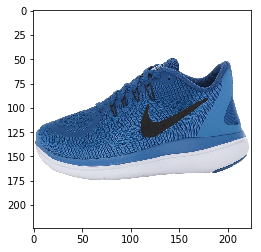

In [36]:
plt.imshow(loaded_data['lateralfrontleft'])